In [1]:
!pip install -q cassio datasets langchain openai tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.7 MB/s eta 0:00:00


In [ ]:
pip install pypdf2 langchain-community

create a  **_Serverless Cassandra with Vector Search_** database on [Astra DB](https://astra.datastax.com) to run this demo.  


In [7]:
#@title importing the libraries

# LangChain components to use
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings

# Support for dataset retrieval with Hugging Face
from datasets import load_dataset

# With CassIO, the engine powering the Astra DB integration in LangChain,
# you will also initialize the DB connection:
import cassio

## read pdf
from PyPDF2 import PdfReader

In [8]:
#@title setup

ASTRA_DB_APPLICATION_TOKEN = "*********"
ASTRA_DB_ID = "*********" # enter your Database ID

OPENAI_API_KEY= "*********"

In [9]:
pip install -q astrapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 23.9 MB/s eta 0:00:00


In [11]:
#@title connect to "astra db"
from astrapy import DataAPIClient

# Initialize the client
client = DataAPIClient(ASTRA_DB_APPLICATION_TOKEN)
db = client.get_database_by_api_endpoint(
  "https://e3e0e09f-f8ba-4720-9f03-a361c161871d-us-east1.apps.astra.datastax.com"
)

print(f"Connected to Astra DB: {db.list_collection_names()}")

Connected to Astra DB: []


In [12]:
#@title load pdf

pdfreader = PdfReader('budget_speech.pdf')

In [13]:
from typing_extensions import Concatenate
# read text from pdf
raw_text = ''
for i, page in enumerate(pdfreader.pages):
    content = page.extract_text()
    if content:
        raw_text += content

In [14]:
raw_text

'GOVERNMENT OF INDIA\nBUDGET 2025-2026\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2025 \nCONTENTS  \n \nPART – A \n Page No.  \nIntroduction  1 \nBudget Theme  1 \nAgriculture as the 1st engine  3 \nMSMEs as the 2nd engine  6 \nInvestment as the 3rd engine  8 \nA. Investing in People  8 \nB. Investing in  the Economy  10 \nC. Investing in Innovation  14 \nExports as the 4th engine  15 \nReforms as the Fuel  16 \nFiscal Policy  18 \n \n \nPART – B \nIndirect taxes  20 \nDirect Taxes   23 \n \nAnnexure to Part -A 29 \nAnnexure to Part -B 31 \n \n   \n \nBudget 202 5-2026 \n \nSpeech of  \nNirmala Sitharaman  \nMinister of Finance  \nFebruary 1 , 202 5 \nHon’ble Speaker,  \n I present the Budget for 2025 -26. \nIntroduction  \n1. This Budget continues our Government ’s efforts to:  \na) accelerate growth,  \nb) secure inclusive development,  \nc) invigorate private sector investments,  \nd) uplift household sentiments, and \ne) enhance spending power of India’s ris

In [15]:
#@title Initialize the connection to your database:

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

In [16]:
#@title Create the LangChain embedding and LLM objects for later usage:

llm = OpenAI(openai_api_key=OPENAI_API_KEY)
embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)


/tmp/ipython-input-16-3792702831.py:3: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(openai_api_key=OPENAI_API_KEY)
/tmp/ipython-input-16-3792702831.py:4: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)


In [17]:
#@title Create LangChain vector store **(backed by Astra DB)**

"""
we pass three parameters
1. embedding we gonna use
2. table name inside db
3. session and keyspace = None
"""

astra_vector_store = Cassandra(
    embedding=embedding,
    table_name="pdf_query_demo",
    session=None,
    keyspace=None,
)

In [18]:
astra_vector_store

In [19]:
#@title data chunks and text embedding

from langchain.text_splitter import CharacterTextSplitter
# We need to split the text using Character Text Split such that it sshould not increse token size
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 800,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_text(raw_text)

In [20]:
len(texts)

155

In [21]:
type(texts)

list

In [22]:
texts[:30]

['GOVERNMENT OF INDIA\nBUDGET 2025-2026\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2025 \nCONTENTS  \n \nPART – A \n Page No.  \nIntroduction  1 \nBudget Theme  1 \nAgriculture as the 1st engine  3 \nMSMEs as the 2nd engine  6 \nInvestment as the 3rd engine  8 \nA. Investing in People  8 \nB. Investing in  the Economy  10 \nC. Investing in Innovation  14 \nExports as the 4th engine  15 \nReforms as the Fuel  16 \nFiscal Policy  18 \n \n \nPART – B \nIndirect taxes  20 \nDirect Taxes   23 \n \nAnnexure to Part -A 29 \nAnnexure to Part -B 31 \n \n   \n \nBudget 202 5-2026 \n \nSpeech of  \nNirmala Sitharaman  \nMinister of Finance  \nFebruary 1 , 202 5 \nHon’ble Speaker,  \n I present the Budget for 2025 -26. \nIntroduction  \n1. This Budget continues our Government ’s efforts to:  \na) accelerate growth,',
 'Minister of Finance  \nFebruary 1 , 202 5 \nHon’ble Speaker,  \n I present the Budget for 2025 -26. \nIntroduction  \n1. This Budget continues our Government

In [23]:
#@title Load the dataset into the vector store

## Astra db has openai embeddding initialzed
## Now when we insert/add pdf texts(which are in chunk form) the embedding will be apply on text chunks

astra_vector_store.add_texts(texts[:50]) # performing embedding on top 50 text chunks

print("Inserted %i headlines." % len(texts[:50]))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)  # wrapping th vectors

Inserted 50 headlines.


### Run the QA cycle

Simply run the cells and ask a question -- or `quit` to stop. (you can also stop execution with the "▪" button on the top toolbar)

Here are some suggested questions:
- _What is the current GDP?_
- _How much the agriculture target will be increased to and what the focus will be_
- _what is the budget for education and healthcare?_

In [25]:
#@title query the astra db (vector store)

first_question = True
while True:
    if first_question:
        query_text = input("\nEnter your question (or type 'quit' to exit): ").strip()
    else:
        query_text = input("\nWhat's your next question (or type 'quit' to exit): ").strip()

    if query_text.lower() == "quit":
        break

    if query_text == "":
        continue

    first_question = False

    """
    when we give first question what will happen:
    it will go ahead with astra vector index and it will query(user question)
    use the llm(here openai) to answer the question
    """

    print("\nQUESTION: \"%s\"" % query_text)
    answer = astra_vector_index.query(query_text, llm=llm).strip()
    print("ANSWER: \"%s\"\n" % answer)

    print("FIRST DOCUMENTS BY RELEVANCE:")
    for doc, score in astra_vector_store.similarity_search_with_score(query_text, k=4):
        print("    [%0.4f] \"%s ...\"" % (score, doc.page_content[:84]))


Enter your question (or type 'quit' to exit): what is the budget for education and healthcare?



QUESTION: "what is the budget for education and healthcare?"
ANSWER: "The budget for education and healthcare is not specifically mentioned in the given context. The total outlay for Artificial Intelligence in education is set at `500 crore, and 10,000 additional seats will be added in medical colleges and hospitals in the next year. Day Care Cancer Centers will be set up in all district hospitals, and a Deep Tech Fund of Funds will be explored to promote medical tourism and investment in innovation. However, the exact budget for education and healthcare is not stated."

FIRST DOCUMENTS BY RELEVANCE:


    [0.9082] "in Artificial Intelligence for education will be set up with a total outlay of ` 500 ..."
    [0.9037] "for certain tourist groups.  
77. Continuing with the emphasis on places of spiritua ..."
    [0.9008] "Minister of Finance  
February 1 , 202 5 
Hon’ble Speaker,  
 I present the Budget f ..."
    [0.8966] "realize ‘Sabka Vikas’, stimulating balanced growth of all regions.  
5. The great Te ..."

What's your next question (or type 'quit' to exit): How much the agriculture target will be increased to and what the focus will be?

QUESTION: "How much the agriculture target will be increased to and what the focus will be?"


ANSWER: "The agriculture target will be increased to 100 developing agri-districts and the focus will be on spurring agricultural growth and productivity."

FIRST DOCUMENTS BY RELEVANCE:


    [0.9137] "rural areas so that migration is an option, but not a necessity.  
12. The programme ..."
    [0.9124] "and training support to makhana farmers and will also work to ensure they 
receive t ..."
    [0.9122] "f) farmers making our country the ‘food basket of the world’.  
6. In this Budget, t ..."
    [0.9120] "Seafood exports are valued at ` 60 thousand crore. To unlock the untapped 
potential ..."

What's your next question (or type 'quit' to exit): quit


Attach image here:

![](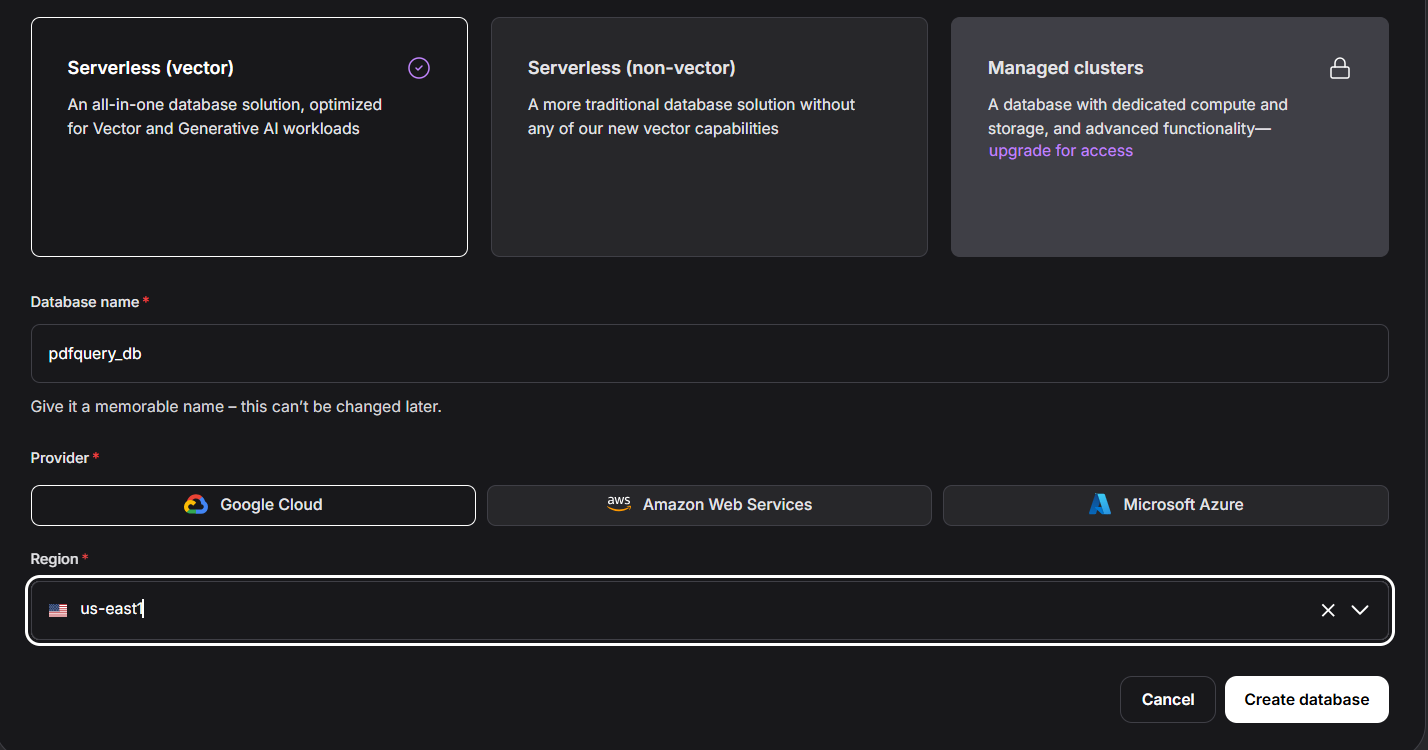)